In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

1. 화재 분류 라벨링 완성
2. 노인주거지수 리 별로 되있는거 대략 위도 경도 변환 후에 각 격자에 넣기 
3. 비닐하우스 데이터 중에서 기간 안에 존치된 비닐하우스 골라내서 api로 위도 경도 변환 후에 기간 고려해서 격자에 넣기
4. 날씨 데이터 중에서 온도, 습도, 강수량 골라내서 전 지역 격자에 넣기
5. 명절 api 찾아내서 명절에 대한 라벨링 실시
6. 준비된 데이터: 월, 주, 격자 x, 격자 y, 화재분류, 노인주거지수, 비닐하우스 분포, 온도, 습도, 강수량, 다음 7일 내 명절 여부, 화재발생여부
7. 1~8: 1주차, 9~16: 2주차, 17~24: 3주차, 25~말일: 4주차

- x: 0-14, y: 0-14, date: 2012.01.01-2022.12.31
- 일단 월별예측 기준으로
- 날씨 데이터는 날짜별 데이터
- 인구분포 데이터는 년도 및 좌표별 데이터
- 임야화재 분포도는 좌표별 데이터

In [2]:
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

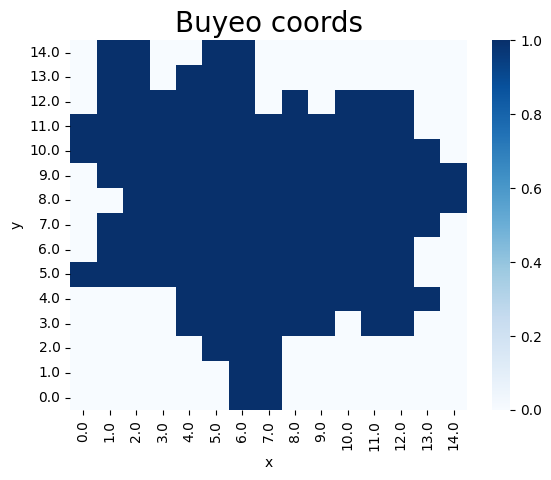

In [3]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [4]:
# 날씨 년도마다 월별로 평균내기
df_pre_weather = df_weather.groupby(['년', '월']).mean().drop(columns='일').reset_index()
df_pre_weather.head()

,년,월,평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도\n(%),일강수량(mm),평균 풍속(m/s)
0,2012,1,-2.051613,-6.725806,3.083871,64.370968,0.516129,1.232258
1,2012,2,-1.534483,-7.162069,4.400000,55.113793,0.110345,1.448276
2,2012,3,4.906452,-0.461290,10.461290,61.132258,1.941935,1.816129
3,2012,4,11.683333,4.920000,19.040000,61.486667,3.643333,1.816667
4,2012,5,18.535484,12.545161,25.703226,59.287097,0.629032,1.383871


In [5]:
# 좌표별 임야 화재 횟수 세기
df_field_fire = df_fire[df_fire['화재구분'] == '임야'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_field_fire.head()

,x,y,화재구분
0,0.0,5.0,1
1,0.0,10.0,2
2,1.0,5.0,3
3,1.0,6.0,1
4,1.0,7.0,2


In [6]:
# 좌표별 비닐하우스 화재 횟수 세기
df_green_fire = df_fire[df_fire['화재구분'] == '비닐하우스'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_green_fire.head()

,x,y,화재구분
0,0.0,11.0,2
1,1.0,5.0,1
2,1.0,6.0,2
3,1.0,10.0,1
4,1.0,11.0,1


In [7]:
# 날짜 및 좌표별 화재횟수 세기
df_pre_fire = df_fire.groupby(['년', '월', 'x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_pre_fire.head()

,년,월,x,y,화재구분
0,2012,1,2.0,6.0,1
1,2012,1,4.0,6.0,1
2,2012,1,5.0,11.0,1
3,2012,1,5.0,12.0,1
4,2012,1,6.0,9.0,2


In [8]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = list(np.arange(start=2012, stop=2023))
month = list(np.arange(start=1, stop=13))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

17952

In [9]:
full_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    pop_result =  df_pop[
        (df_pop['연도'] == date_coord[0][0]) &
        (df_pop['x'] == date_coord[1][0]) &
        (df_pop['y'] == date_coord[1][1])
    ]

    if len(pop_result) == 0:
        feat.append(0.)
        feat.append(0.)
    else:
        feat.append(pop_result.iloc[0]['인구수비율'])
        feat.append(pop_result.iloc[0]['60세이상노인인구수비율'])

    # 날짜 및 좌표별 창고개수 추가: 창고개수
    storage_date = int(str(date_coord[0][0]) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    storage_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= storage_date) & 
        (df_buildings['실질적철거일'] >= storage_date) &
        (df_buildings['기타용도'] == '창고')
    ]

    feat.append(len(storage_result))

    # 날짜 및 좌표별 축사, 균사개수 추가: 축균사개수
    barn_spawn_date = int(str(date_coord[0][0]) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    barn_spawn_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= barn_spawn_date) & 
        (df_buildings['실질적철거일'] >= barn_spawn_date) &
        ((df_buildings['기타용도'] == '축사') | (df_buildings['기타용도'] == '균사'))
    ]

    feat.append(len(barn_spawn_result))
    
    # 날씨 데이터 추가: 평균기온, 최저기온, 최고기온, 평균 상대습도, 일강수량, 평균 풍속
    weather_result = df_weather[
        (df_weather['년'] == date_coord[0][0]) & 
        (df_weather['월'] == date_coord[0][1])
    ]

    feat.append(weather_result.iloc[0]['평균기온(°C)'])
    feat.append(weather_result.iloc[0]['최저기온(°C)'])
    feat.append(weather_result.iloc[0]['최고기온(°C)'])
    feat.append(weather_result.iloc[0]['평균 상대습도\n(%)'])
    feat.append(weather_result.iloc[0]['일강수량(mm)'])
    feat.append(weather_result.iloc[0]['평균 풍속(m/s)'])

    # 좌표별 임야화재횟수 추가: 임야화재횟수
    field_result = df_field_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])

    # 좌표별 비닐하우스화재횟수 추가: 비닐하우스화재횟수
    green_result = df_green_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])
    
    # 날짜 및 좌표별 화재횟수 추가(output): 화재횟수
    fire_result = df_pre_fire[
        (df_pre_fire['년'] == date_coord[0][0]) &
        (df_pre_fire['월'] == date_coord[0][1]) &
        (df_pre_fire['x'] == date_coord[1][0]) &
        (df_pre_fire['y'] == date_coord[1][1])
    ]

    if len(fire_result) == 0:
        feat.append(0.)
    else:
        feat.append(1.)

    full_feats.append(feat)

In [11]:
# 년, 월, x, y, 인구수비율, 60세이상노인인구수비율, 창고개수, 축균사개수, 평균기온, 최저기온, 최고기온, 평균상대습도, 
# 일강수량, 평균풍속, 임야화재횟수, 비닐하우스화재횟수, 화재횟수
df = pd.DataFrame(full_feats, columns=[
    'year', 'month', 'x', 'y', 'pop_rate', 'old_pop_rate', 'sto_num', 'barn_spwn_num', 'avg_temp', 'min_temp', 'max_temp', 'avg_hum', 
    'daily_pre', 'avg_wind', 'field_fire', 'green_fire', 'fire'
])
df.head()

,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
0,2012,1,0.0,11.0,0.012300,0.012723,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0,0.0
1,2012,1,1.0,5.0,0.004109,0.007010,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,3.0,3.0,0.0
2,2012,1,1.0,6.0,0.005297,0.008671,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,1.0,1.0,0.0
3,2012,1,1.0,7.0,0.001939,0.002958,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,2.0,2.0,0.0
4,2012,1,1.0,9.0,0.001038,0.001661,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0,0.0


In [13]:
# 스케일링되지 않은 데이터 저장
df.to_csv('./data/non_scaled_data.csv', encoding='utf-8-sig', index=False)

In [25]:
# MinMaxScaler로 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['x'] = scaler.fit_transform(df['x'].values.reshape(-1, 1))
df['y'] = scaler.fit_transform(df['y'].values.reshape(-1, 1))
df['pop_rate'] = scaler.fit_transform(df['pop_rate'].values.reshape(-1, 1))
df['old_pop_rate'] = scaler.fit_transform(df['old_pop_rate'].values.reshape(-1, 1))
df['sto_num'] = scaler.fit_transform(df['sto_num'].values.reshape(-1, 1))
df['barn_spwn_num'] = scaler.fit_transform(df['barn_spwn_num'].values.reshape(-1, 1))
df['avg_temp'] = scaler.fit_transform(df['avg_temp'].values.reshape(-1, 1))
df['min_temp'] = scaler.fit_transform(df['min_temp'].values.reshape(-1, 1))
df['max_temp'] = scaler.fit_transform(df['max_temp'].values.reshape(-1, 1))
df['avg_hum'] = scaler.fit_transform(df['avg_hum'].values.reshape(-1, 1))
df['daily_pre'] = scaler.fit_transform(df['daily_pre'].values.reshape(-1, 1))
df['avg_wind'] = scaler.fit_transform(df['avg_wind'].values.reshape(-1, 1))
df['field_fire'] = scaler.fit_transform(df['field_fire'].values.reshape(-1, 1))
df['green_fire'] = scaler.fit_transform(df['green_fire'].values.reshape(-1, 1))


In [26]:
df = df.drop(columns=['year'])
df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
0,1,0.000000,0.785714,0.099192,0.174844,0.0,0.0,0.145078,0.14876,0.07767,0.540441,0.008021,0.393939,0.000000,0.000000,0.0
1,1,0.071429,0.357143,0.033137,0.096331,0.0,0.0,0.145078,0.14876,0.07767,0.540441,0.008021,0.393939,0.214286,0.214286,0.0
2,1,0.071429,0.428571,0.042715,0.119161,0.0,0.0,0.145078,0.14876,0.07767,0.540441,0.008021,0.393939,0.071429,0.071429,0.0
3,1,0.071429,0.500000,0.015633,0.040648,0.0,0.0,0.145078,0.14876,0.07767,0.540441,0.008021,0.393939,0.142857,0.142857,0.0
4,1,0.071429,0.642857,0.008367,0.022830,0.0,0.0,0.145078,0.14876,0.07767,0.540441,0.008021,0.393939,0.000000,0.000000,0.0


In [2]:
# 데이터 저장
df.to_csv('./data/preprocessed_data.csv', encoding='utf-8-sig', index=False)